In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import dateutil.parser
import datetime

In [3]:
# 68,335,729 data points in total
import random
p = 0.0001  # 0.01% of the lines -> 6800 data points
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
"""
df = pd.read_csv(
         'data/all_events.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
"""
# df = pd.read_csv('../data/Kiasma_sorted.csv', nrows=1000000, low_memory=False)
df = pd.read_csv('../data/AaltoyliopistoMKorkeakouluaukio_sorted.csv')

## Drop duplicated based on timestamp

In [4]:
df = df.drop_duplicates('ts').reset_index()

## Add some useful columns

In [5]:
# sort based on timestamp
df = df.sort_values('ts')
# the hour and minutes of the timestamp
df['hour_and_minutes'] = df['ts'].apply(lambda x: x[11:16])
# month of timestamp
df['month'] = df['ts'].apply(lambda x: x[5:7])
# the percentage of bikes
df['bikes_percent'] = df['bikes'] / df['total_slots']
df['minutes_from_midnight'] = df['ts'].apply(lambda x: int(x[11:13]) * 60 + int(x[14:16]))
df['hour'] = df['hour_and_minutes'].apply(lambda x: x[:2])
df['date'] = df['ts'].apply(pd.to_datetime)
df['weekday'] = df['date'].apply(lambda x: x.weekday())
df['weekend'] = df['weekday'].apply(lambda x: x > 4)
df.head()

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,07,2018-05-11 07:48:01,4,False
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,07,2018-05-11 07:49:01,4,False
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,07,2018-05-11 07:50:01,4,False
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,07,2018-05-11 07:51:01,4,False
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,07,2018-05-11 07:52:01,4,False


## Explore 

In [6]:
df.shape

(128023, 17)

In [7]:
df.describe()

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday
count,128023.000000,1.280230e+05,1.280230e+05,128023.0,128023.0,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000
mean,64879.642674,6.018431e+01,2.482667e+01,1.0,541.0,7.830398,40.599752,0.192926,732.632800,3.040883
std,38422.483995,4.872211e-11,6.656390e-11,0.0,0.0,9.516940,0.489950,0.234671,404.983005,1.993114
min,0.000000,6.018431e+01,2.482667e+01,1.0,541.0,0.000000,40.000000,0.000000,0.000000,0.000000
25%,32005.500000,6.018431e+01,2.482667e+01,1.0,541.0,1.000000,40.000000,0.024390,388.000000,1.000000
50%,64011.000000,6.018431e+01,2.482667e+01,1.0,541.0,4.000000,41.000000,0.097561,734.000000,3.000000
75%,96016.500000,6.018431e+01,2.482667e+01,1.0,541.0,12.000000,41.000000,0.292683,1081.000000,5.000000
max,142935.000000,6.018431e+01,2.482667e+01,1.0,541.0,60.000000,41.000000,1.463415,1439.000000,6.000000


In [8]:
df.head(10)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,07,2018-05-11 07:48:01,4,False
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,07,2018-05-11 07:49:01,4,False
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,07,2018-05-11 07:50:01,4,False
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,07,2018-05-11 07:51:01,4,False
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,07,2018-05-11 07:52:01,4,False
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,07,2018-05-11 07:53:01,4,False
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,07,2018-05-11 07:54:01,4,False
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,07,2018-05-11 07:55:01,4,False
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,07,2018-05-11 07:56:01,4,False
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,07,2018-05-11 07:57:01,4,False


In [9]:
by_hour = df.groupby('hour_and_minutes').mean()[0::60]
by_hour

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,weekend
hour_and_minutes,,,,,,,,,,,
00:00,70033.438356,60.184312,24.826671,1.0,541.0,2.602740,40.657534,0.064116,0.0,3.328767,0.369863
01:00,66275.750000,60.184312,24.826671,1.0,541.0,2.222222,40.597222,0.054887,60.0,3.250000,0.375000
02:00,64796.619718,60.184312,24.826671,1.0,541.0,2.591549,40.577465,0.063956,120.0,3.169014,0.338028
03:00,65809.197674,60.184312,24.826671,1.0,541.0,2.604651,40.604651,0.064180,180.0,3.011628,0.302326
04:00,64574.955556,60.184312,24.826671,1.0,541.0,5.022222,40.588889,0.123598,240.0,3.000000,0.288889
05:00,64400.750000,60.184312,24.826671,1.0,541.0,10.318182,40.590909,0.254164,300.0,2.931818,0.272727
06:00,64976.793478,60.184312,24.826671,1.0,541.0,12.847826,40.597826,0.316576,360.0,3.021739,0.293478
07:00,65043.728261,60.184312,24.826671,1.0,541.0,13.152174,40.597826,0.324032,420.0,3.021739,0.293478
08:00,64410.591398,60.184312,24.826671,1.0,541.0,12.827957,40.591398,0.315978,480.0,3.032258,0.290323


Text(0.5,1,'Bikes percentage each hour')

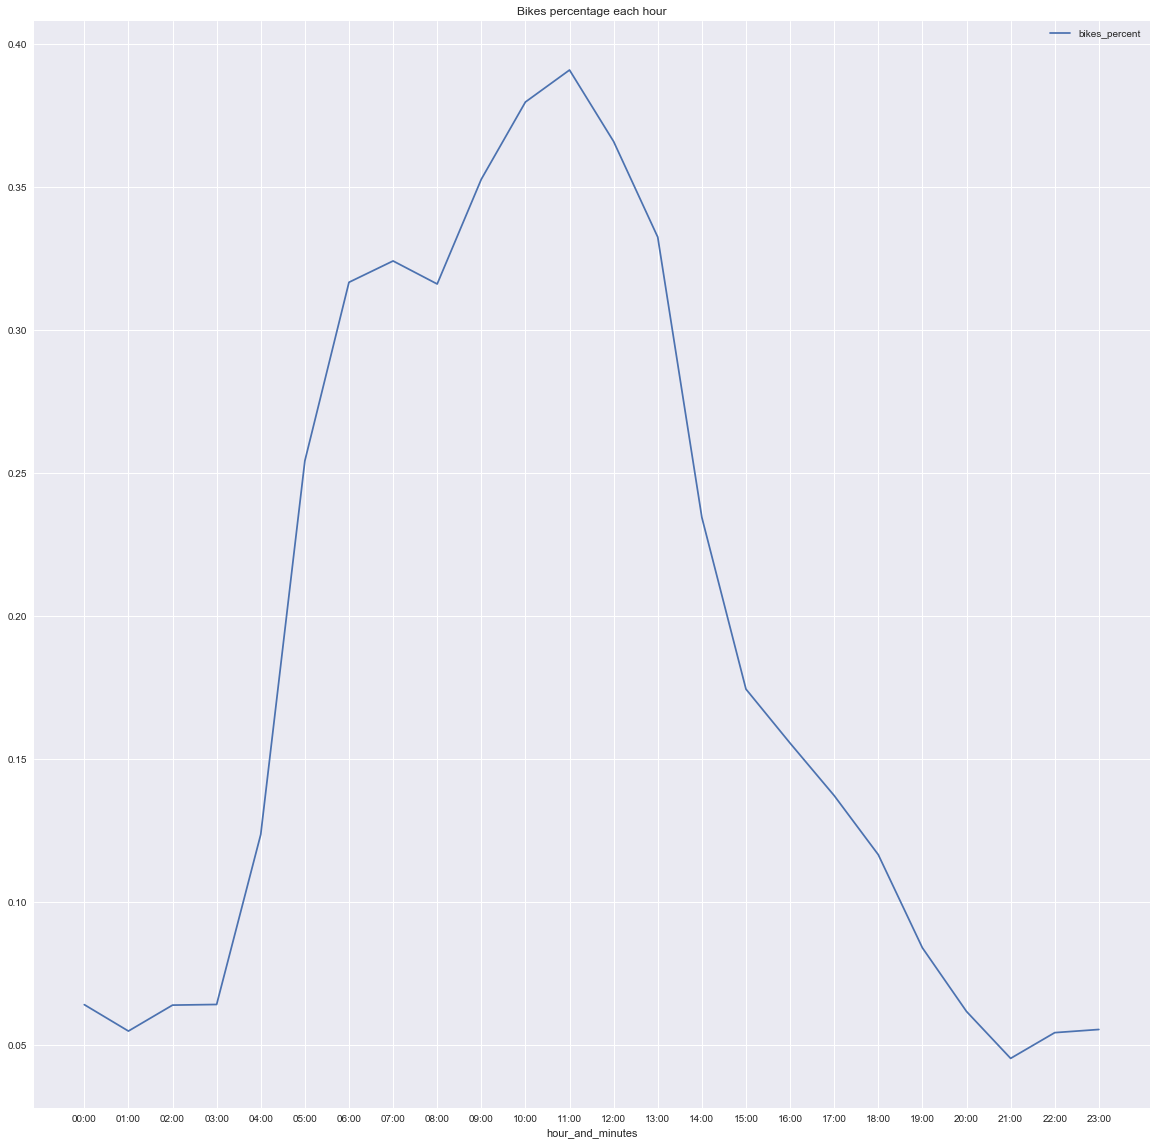

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
by_hour.plot(y='bikes_percent', ax=ax)
ax.set_xticks(range(len(by_hour.index)))
ax.set_xticklabels(by_hour.index)
plt.title('Bikes percentage each hour')

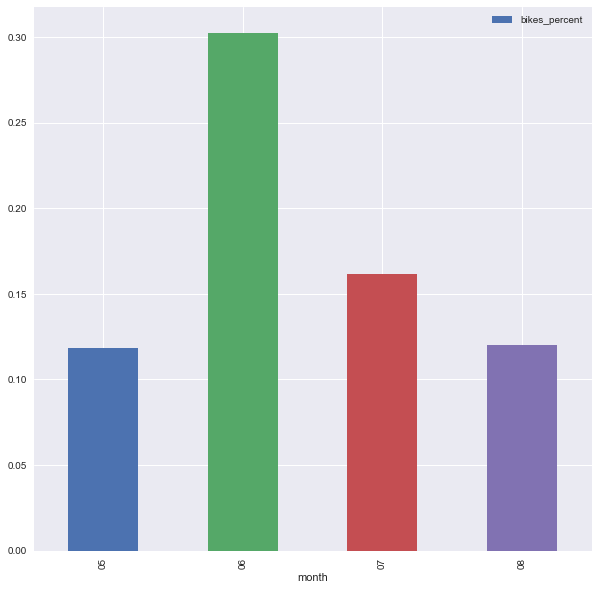

In [11]:
by_month = df.groupby('month').mean()
by_month.plot(y='bikes_percent', kind='bar', figsize=(10, 10))

In [12]:
# this is useful when using data from several stations
by_name = df.groupby('name').mean()
by_name

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,weekend
name,,,,,,,,,,,
"Aalto-yliopisto (M), Korkeakouluaukio",64879.642674,60.184312,24.826671,1.0,541.0,7.830398,40.599752,0.192926,732.6328,3.040883,0.292229


## Prepare for predictions

### Add column which states whether a bike was added at a given moment

In [13]:
df['bike_added'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] < x['bikes'] , axis=1)
df['bike_removed'] = df.apply(lambda x: df.iloc[(x.name - 1 if x.name > 0 else 0)]['bikes'] > x['bikes'] , axis=1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,month,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend,bike_added,bike_removed
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,05,0.125,468,07,2018-05-11 07:48:01,4,False,False,False
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,05,0.100,469,07,2018-05-11 07:49:01,4,False,False,True
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,05,0.100,470,07,2018-05-11 07:50:01,4,False,False,False
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,05,0.100,471,07,2018-05-11 07:51:01,4,False,False,False
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,05,0.100,472,07,2018-05-11 07:52:01,4,False,False,False
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,05,0.100,473,07,2018-05-11 07:53:01,4,False,False,False
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,05,0.100,474,07,2018-05-11 07:54:01,4,False,False,False
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,05,0.100,475,07,2018-05-11 07:55:01,4,False,False,False
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,05,0.100,476,07,2018-05-11 07:56:01,4,False,False,False
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,05,0.100,477,07,2018-05-11 07:57:01,4,False,False,False


### Add max waiting time for next bike

In [14]:
# extract difference in minutes to a separate column
# on the moment that a bike was added, the waiting time is the time to next bike
i = 0
first_non_additive_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_added'] == False):
        i += 1
    if (i >= len(df)):
        break
    additive_row = df.iloc[i]
    time = additive_row['minutes_from_midnight']
    difference = abs(time - df.iloc[first_non_additive_index]['minutes_from_midnight'])
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike'] = difference 
    date_time = additive_row['date']
    last_date = df.iloc[first_non_additive_index]['date']
    date_difference = abs((date_time - last_date).total_seconds() / 60)
    df.loc[first_non_additive_index:(i-1 if i > 0 else 0), 'max_wait_for_new_bike_as_date'] = date_difference 
    first_non_additive_index = i
    i += 1
# if we can't know when the next bike will be added, fill with -1 for now
df = df.fillna(-1)
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,bikes_percent,minutes_from_midnight,hour,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,0.125,468,07,2018-05-11 07:48:01,4,False,False,False,16.0,16.0
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,0.100,469,07,2018-05-11 07:49:01,4,False,False,True,16.0,16.0
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,0.100,470,07,2018-05-11 07:50:01,4,False,False,False,16.0,16.0
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,0.100,471,07,2018-05-11 07:51:01,4,False,False,False,16.0,16.0
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,0.100,472,07,2018-05-11 07:52:01,4,False,False,False,16.0,16.0
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,0.100,473,07,2018-05-11 07:53:01,4,False,False,False,16.0,16.0
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,0.100,474,07,2018-05-11 07:54:01,4,False,False,False,16.0,16.0
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,0.100,475,07,2018-05-11 07:55:01,4,False,False,False,16.0,16.0
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,0.100,476,07,2018-05-11 07:56:01,4,False,False,False,16.0,16.0
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,0.100,477,07,2018-05-11 07:57:01,4,False,False,False,16.0,16.0


### Add idle time for each station

In [15]:
i = 0
idle_for = 0
idle_for_as_date = 0
while (i < len(df)):
    row = df.iloc[i]
    previous_row = df.iloc[(i-1 if i > 0 else 0)]
    if (not row['bikes'] == previous_row['bikes']):
        idle_for = 0
        idle_for_as_date = 0
        df.loc[i, 'idle_for'] = idle_for
        df.loc[i, 'idle_for_as_date'] = idle_for_as_date        
        i+= 1
        continue
    time_now = row['minutes_from_midnight']
    time_last = previous_row['minutes_from_midnight']
    date_time_now = row['date']
    date_time_last = previous_row['date']
    idle_for += abs(time_now - time_last)
    secs = (date_time_now - date_time_last).total_seconds()
    idle_for_as_date += abs(secs / 60)
    df.loc[i, 'idle_for'] = idle_for
    df.loc[i, 'idle_for_as_date'] = idle_for_as_date
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,hour,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,idle_for,idle_for_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,07,2018-05-11 07:48:01,4,False,False,False,16.0,16.0,0.0,0.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,07,2018-05-11 07:49:01,4,False,False,True,16.0,16.0,0.0,0.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,07,2018-05-11 07:50:01,4,False,False,False,16.0,16.0,1.0,1.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,07,2018-05-11 07:51:01,4,False,False,False,16.0,16.0,2.0,2.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,07,2018-05-11 07:52:01,4,False,False,False,16.0,16.0,3.0,3.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,07,2018-05-11 07:53:01,4,False,False,False,16.0,16.0,4.0,4.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,07,2018-05-11 07:54:01,4,False,False,False,16.0,16.0,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,07,2018-05-11 07:55:01,4,False,False,False,16.0,16.0,6.0,6.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,07,2018-05-11 07:56:01,4,False,False,False,16.0,16.0,7.0,7.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,07,2018-05-11 07:57:01,4,False,False,False,16.0,16.0,8.0,8.000000


In [16]:
df.head(100)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,hour,date,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,idle_for,idle_for_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,07,2018-05-11 07:48:01,4,False,False,False,16.0,16.0,0.0,0.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,07,2018-05-11 07:49:01,4,False,False,True,16.0,16.0,0.0,0.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,07,2018-05-11 07:50:01,4,False,False,False,16.0,16.0,1.0,1.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,07,2018-05-11 07:51:01,4,False,False,False,16.0,16.0,2.0,2.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,07,2018-05-11 07:52:01,4,False,False,False,16.0,16.0,3.0,3.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,07,2018-05-11 07:53:01,4,False,False,False,16.0,16.0,4.0,4.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,07,2018-05-11 07:54:01,4,False,False,False,16.0,16.0,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,07,2018-05-11 07:55:01,4,False,False,False,16.0,16.0,6.0,6.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,07,2018-05-11 07:56:01,4,False,False,False,16.0,16.0,7.0,7.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,07,2018-05-11 07:57:01,4,False,False,False,16.0,16.0,8.0,8.000000


In [17]:
df.describe()

,index,lat,lon,operative,sid,bikes,total_slots,bikes_percent,minutes_from_midnight,weekday,max_wait_for_new_bike,max_wait_for_new_bike_as_date,idle_for,idle_for_as_date
count,128023.000000,1.280230e+05,1.280230e+05,128023.0,128023.0,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000,128023.000000
mean,64879.642674,6.018431e+01,2.482667e+01,1.0,541.0,7.830398,40.599752,0.192926,732.632800,3.040883,239.543691,95.268873,146.433375,34.819797
std,38422.483995,4.872211e-11,6.656390e-11,0.0,0.0,9.516940,0.489950,0.234671,404.983005,1.993114,421.196981,133.995827,441.413243,70.843195
min,0.000000,6.018431e+01,2.482667e+01,1.0,541.0,0.000000,40.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000
25%,32005.500000,6.018431e+01,2.482667e+01,1.0,541.0,1.000000,40.000000,0.024390,388.000000,1.000000,13.000000,13.000000,2.000000,2.000000
50%,64011.000000,6.018431e+01,2.482667e+01,1.0,541.0,4.000000,41.000000,0.097561,734.000000,3.000000,28.000000,28.000000,6.000000,6.000000
75%,96016.500000,6.018431e+01,2.482667e+01,1.0,541.0,12.000000,41.000000,0.292683,1081.000000,5.000000,102.000000,101.000000,25.000000,24.000000
max,142935.000000,6.018431e+01,2.482667e+01,1.0,541.0,60.000000,41.000000,1.463415,1439.000000,6.000000,1400.000000,593.000000,1937.000000,503.000000


### Add time for next bike take

Predict how much time for the next bike to be taken: max waiting time is not useful here.

In [18]:
i = 0
first_non_removing_index = 0
while (i < len(df)):
    while (i < len(df) and df.iloc[i]['bike_removed'] == False):
        i += 1
    if (i >= len(df)):
        break
    removing_row = df.iloc[i]
    time = removing_row['minutes_from_midnight']
    times_until_now = df.loc[first_non_removing_index:i-1, 'minutes_from_midnight']
    difference = abs(time - times_until_now)
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken'] = difference 
    date_time = removing_row['date']
    date_times_until_now = df.loc[first_non_removing_index:i-1, 'date']
    date_difference = abs((date_time - date_times_until_now).apply(lambda x: x.total_seconds() / 60))
    df.loc[first_non_removing_index:(i-1 if i > 0 else 0), 'wait_for_bike_taken_as_date'] = date_difference 
    first_non_removing_index = i
    i += 1
# if we can't know when the next bike will be taken, fill with -1 for now
df = df.fillna(-1)
df.head(50)

,index,ts,lat,lon,operative,sid,name,bikes,total_slots,hour_and_minutes,...,weekday,weekend,bike_added,bike_removed,max_wait_for_new_bike,max_wait_for_new_bike_as_date,idle_for,idle_for_as_date,wait_for_bike_taken,wait_for_bike_taken_as_date
0,0,2018-05-11T07:48:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",5,40,07:48,...,4,False,False,False,16.0,16.0,0.0,0.000000,1.0,1.000000
1,1,2018-05-11T07:49:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:49,...,4,False,False,True,16.0,16.0,0.0,0.000000,10.0,10.000000
2,2,2018-05-11T07:50:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:50,...,4,False,False,False,16.0,16.0,1.0,1.000000,9.0,9.000000
3,3,2018-05-11T07:51:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:51,...,4,False,False,False,16.0,16.0,2.0,2.000000,8.0,8.000000
4,4,2018-05-11T07:52:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:52,...,4,False,False,False,16.0,16.0,3.0,3.000000,7.0,7.000000
5,5,2018-05-11T07:53:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:53,...,4,False,False,False,16.0,16.0,4.0,4.000000,6.0,6.000000
6,6,2018-05-11T07:54:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:54,...,4,False,False,False,16.0,16.0,5.0,5.000000,5.0,5.000000
7,7,2018-05-11T07:55:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:55,...,4,False,False,False,16.0,16.0,6.0,6.000000,4.0,4.000000
8,8,2018-05-11T07:56:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:56,...,4,False,False,False,16.0,16.0,7.0,7.000000,3.0,3.000000
9,9,2018-05-11T07:57:01,60.184312,24.826671,1,541,"Aalto-yliopisto (M), Korkeakouluaukio",4,40,07:57,...,4,False,False,False,16.0,16.0,8.0,8.000000,2.0,2.000000


## Plot division of max waiting time for new bike

### Sorted by frequency

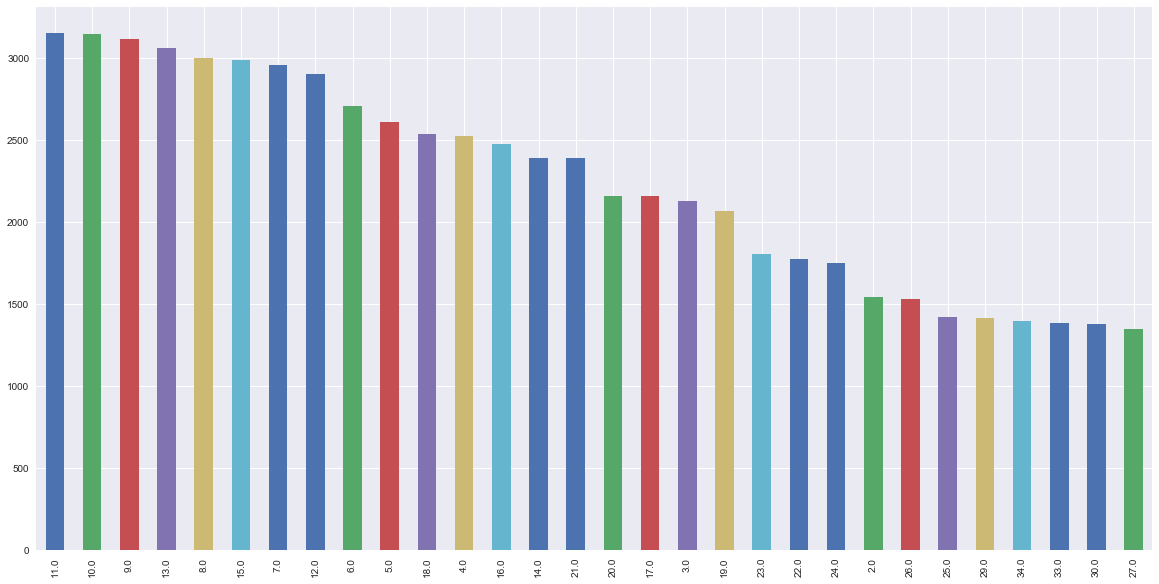

In [19]:
# sort by frequency
by_max_wait = df['max_wait_for_new_bike'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_max_wait.plot(kind='bar', figsize=(20, 10))

### Sorted by waiting time

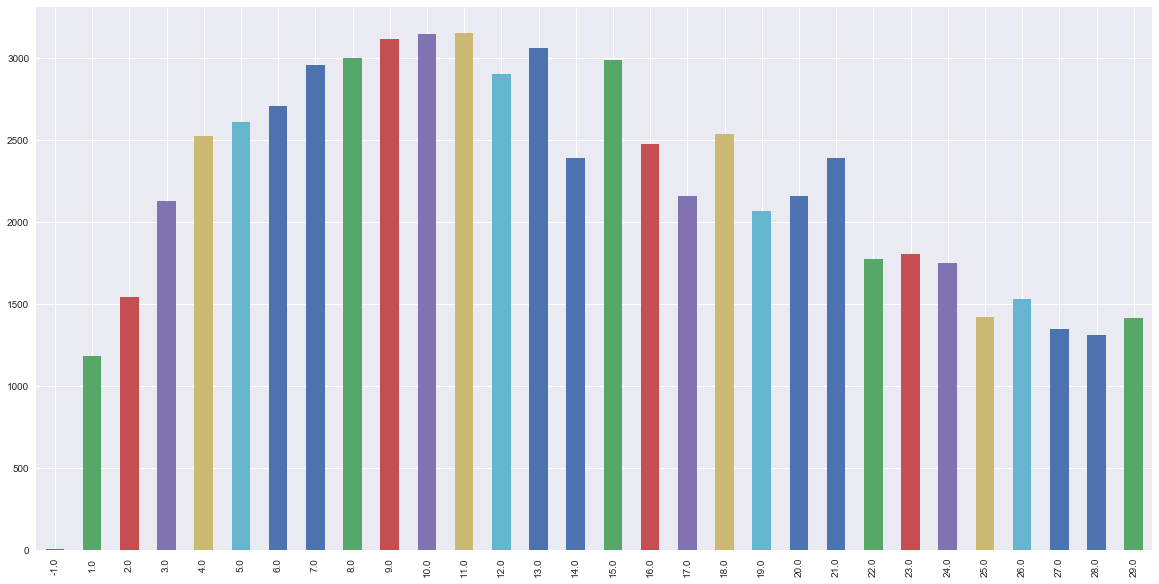

In [20]:
# sort by waiting time
by_max_wait_count = df['max_wait_for_new_bike'].value_counts()
by_max_wait_sorted = by_max_wait_count.sort_index().head(30)
by_max_wait_normalized = by_max_wait_sorted.index
by_max_wait_sorted.plot(kind='bar', figsize=(20, 10))

### Normalized waiting time

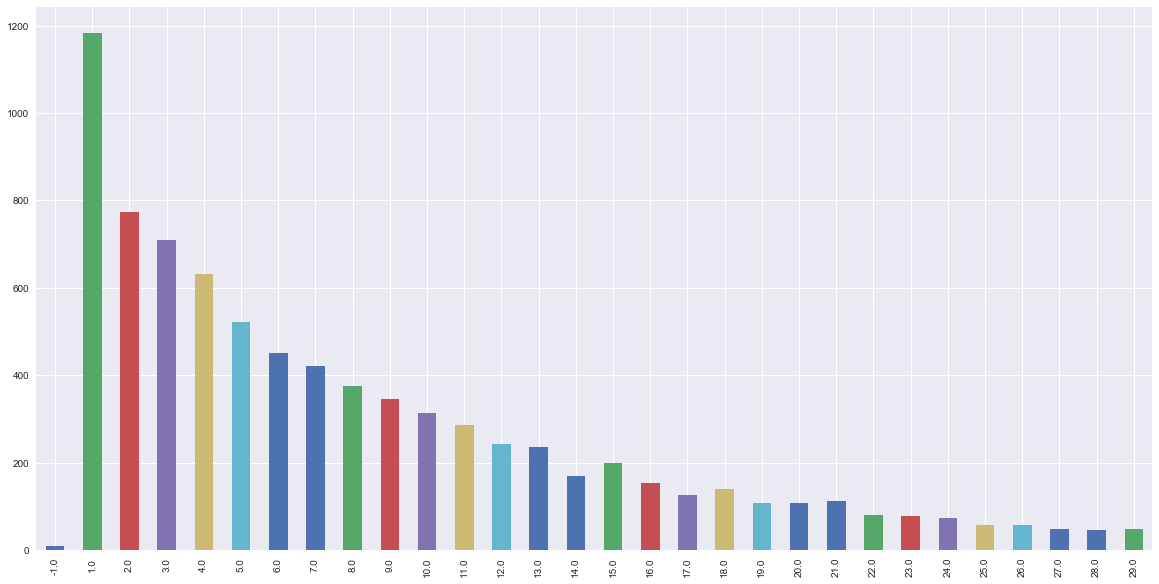

In [21]:
# normalize by dividing by key in order not to emphasize big values
by_max_wait_normalized = abs(by_max_wait_sorted / by_max_wait_sorted.index)
by_max_wait_normalized.plot(kind='bar', figsize=(20, 10))

## Plot distribution of wait for next taken bike

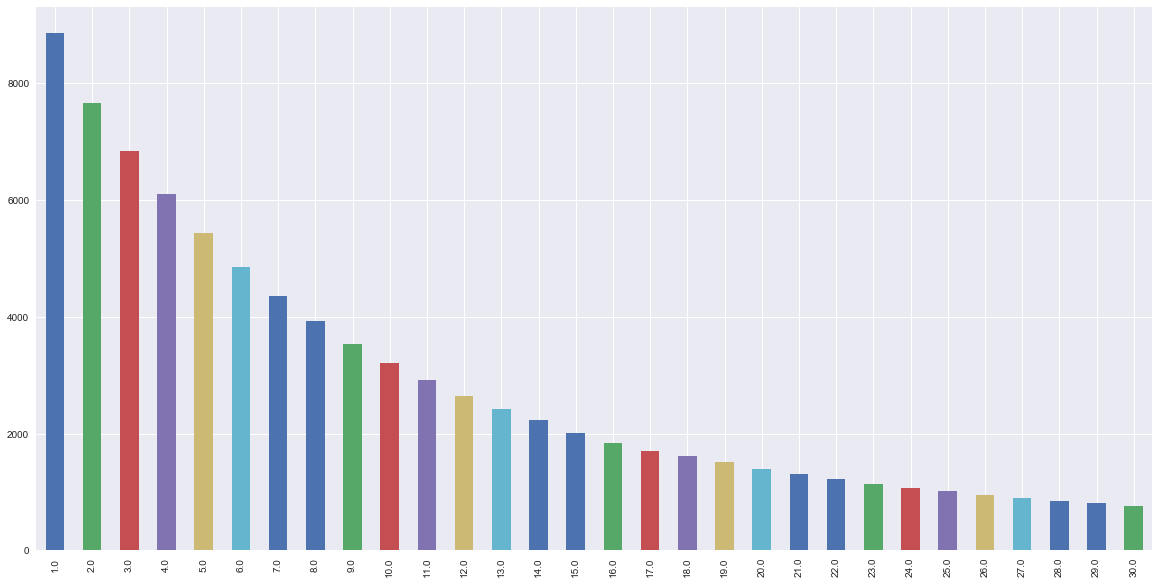

In [22]:
# sort by frequency
by_take_wait = df['wait_for_bike_taken'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Plot distribution of idle time

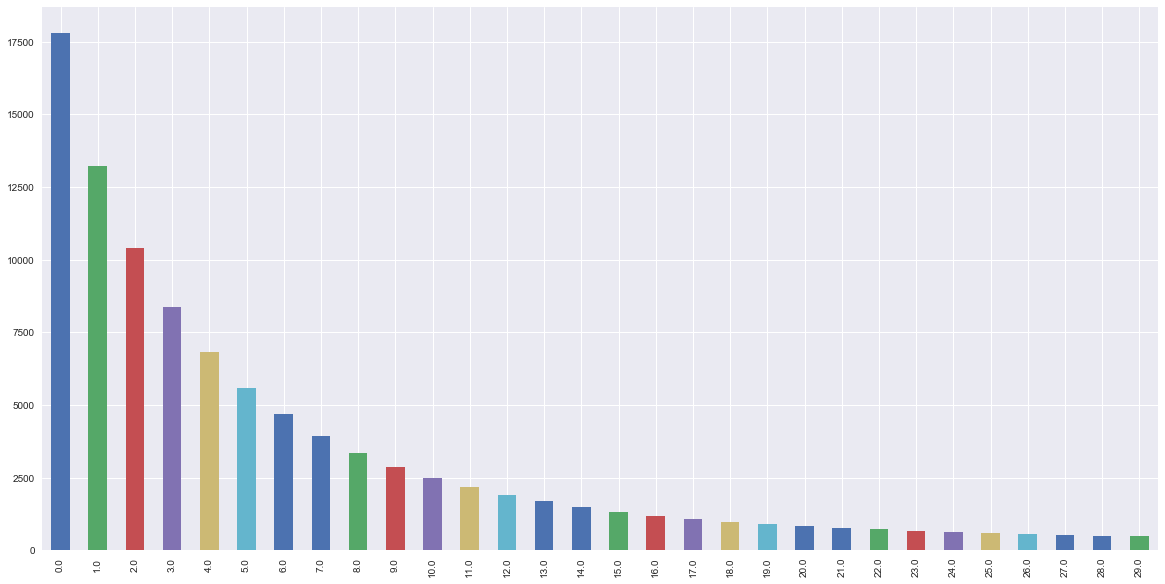

In [23]:
# sort by frequency
by_take_wait = df['idle_for'].value_counts(ascending=True).sort_values(ascending=False).head(30)
by_take_wait.plot(kind='bar', figsize=(20, 10))

## Build linear regression models

### Remove useless or codependent columns

In [53]:
max_wait_counts = df['max_wait_for_new_bike_as_date'].value_counts()
wait_counts = df['wait_for_bike_taken_as_date'].value_counts()

In [62]:
cleaned_df = df.drop(columns=['index', 'ts', 'sid', 'hour_and_minutes', 'name', 'bike_added', 'bike_removed', 'lat', 'lon', 'bikes', 'total_slots', 'minutes_from_midnight', 'date'])
# remove outliers = if theres less than 10 data points of a specific waiting time
filterable_max_waits = max_wait_counts[max_wait_counts < 10].index
filterable_waits = wait_counts[wait_counts < 10].index
cleaned_df = cleaned_df[~cleaned_df['max_wait_for_new_bike_as_date'].isin(filterable_max_waits)]
cleaned_df = cleaned_df[~cleaned_df['wait_for_bike_taken_as_date'].isin(filterable_waits)]
print('removed', len(df) - len(cleaned_df), 'rows')

removed 1979 rows


### Predict when the next bike will be brought

In [63]:
# remove the column to predict
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date
score:


0.6077876688717911

### Predict when the next bike will be taken

In [66]:
# remove the column to predict
x = cleaned_df.drop(columns=['wait_for_bike_taken', 'max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date
score:


0.28673744010255153

### Predict the percentage of bikes at the station

In [67]:
# remove the column to predict
x = cleaned_df.drop(columns=['bikes_percent'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['bikes_percent']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, hour, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date
score:


0.16636827772725538

### Predict the hour based on amount of bikes at station

In [68]:
# remove the column to predict
x = cleaned_df.drop(columns=['hour'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['hour']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
print('score:')
model.score(x_test, y_test)

predicting based on operative, month, bikes_percent, weekday, weekend, max_wait_for_new_bike, max_wait_for_new_bike_as_date, idle_for, idle_for_as_date, wait_for_bike_taken, wait_for_bike_taken_as_date
score:


0.4721353362908182

## Evaluate the model manually 

### Max waiting time for new bike

In [70]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['max_wait_for_new_bike_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date
test dataset length:  25209
percentages of predictions within 1 mins of target: 0.020270538299813557
percentages of predictions within 2 mins of target: 0.04050140822722044
percentages of predictions within 3 mins of target: 0.05890753302392003
percentages of predictions within 4 mins of target: 0.07743266293783967
percentages of predictions within 5 mins of target: 0.09579911936213258
percentages of predictions within 6 mins of target: 0.11297552461422508
percentages of predictions within 7 mins of target: 0.13058828196279107
percentages of predictions within 8 mins of target: 0.14665397278749653
percentages of predictions within 9 mins of target: 0.16184695941925503
percentages of predictions within 10 mins of target: 0.17822999722321392
percentages of predictions within 11 mins of target: 0.19258994803443213
percentages of predictions within 12 mins of target: 0.2062755365147368
percentages

### Waiting time for next bike taken

In [72]:
x = cleaned_df.drop(columns=['max_wait_for_new_bike', 'max_wait_for_new_bike_as_date', 'wait_for_bike_taken', 'wait_for_bike_taken_as_date', 'idle_for'])
print('predicting based on', ', '.join(x.columns.values))
y = cleaned_df['wait_for_bike_taken_as_date']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
model = LinearRegression()
x_train
model.fit(x_train, y_train)
preds = model.predict(x_test)
print('test dataset length: ', len(y_test))
for mins in range(1, 21):
    diff = abs(preds - y_test)
    success = len(diff[diff < mins])
    print('percentages of predictions within {} mins of target: {}'.format(mins, success / len(preds)))

predicting based on operative, month, bikes_percent, hour, weekday, weekend, idle_for_as_date
test dataset length:  25209
percentages of predictions within 1 mins of target: 0.015192986631758498
percentages of predictions within 2 mins of target: 0.032052044904597565
percentages of predictions within 3 mins of target: 0.0473640366535761
percentages of predictions within 4 mins of target: 0.06251735491292792
percentages of predictions within 5 mins of target: 0.0779483517791265
percentages of predictions within 6 mins of target: 0.09429172121067872
percentages of predictions within 7 mins of target: 0.10968304970447063
percentages of predictions within 8 mins of target: 0.12741481217025666
percentages of predictions within 9 mins of target: 0.14324249276052203
percentages of predictions within 10 mins of target: 0.15895116823356736
percentages of predictions within 11 mins of target: 0.17533420603752628
percentages of predictions within 12 mins of target: 0.18997183545559126
percentages